In [ ]:
# configuring path
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/time_series
!pwd

/content/drive/MyDrive/Colab Notebooks/time_series
/content/drive/MyDrive/Colab Notebooks/time_series


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Importing the Keras libraries and packages
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau,TensorBoard,ModelCheckpoint,EarlyStopping

In [ ]:
# load data
df = pd.read_csv('for_time_series_forceasting_pedestrian_count.tsv', sep='\t')
# dataframe hard copy for normalization
df_norm = df.copy()

original data


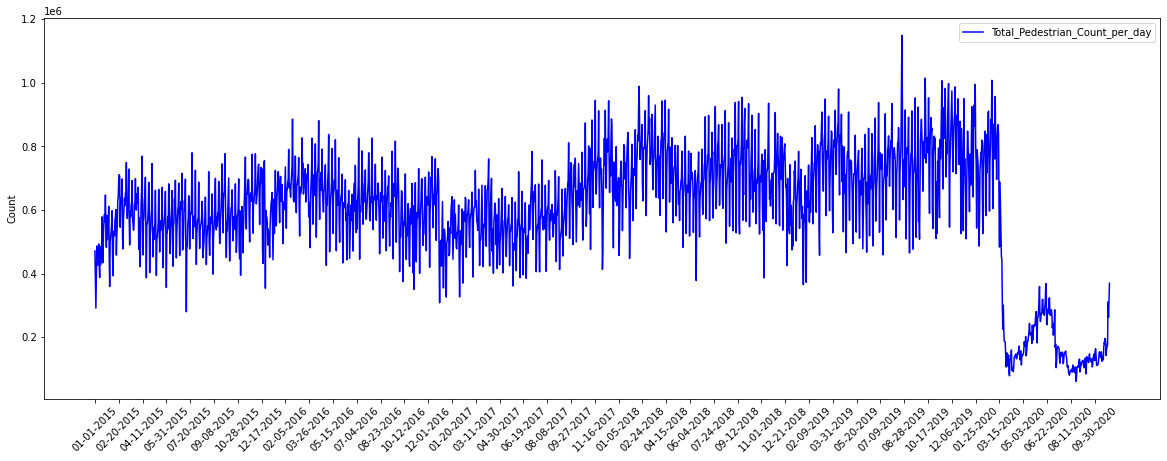

In [ ]:
# show pedestrian count each day
print('original data')
plt.figure(figsize = (20, 7))
plt.plot(range(len(df)), df['Total_Pedestrian_Count_per_day'], color='blue', label='Total_Pedestrian_Count_per_day')
plt.xticks(range(0,len(df),50),df['Date'].loc[::50],rotation=45)
plt.ylabel('Count')
plt.legend()
plt.show()


Normalized data


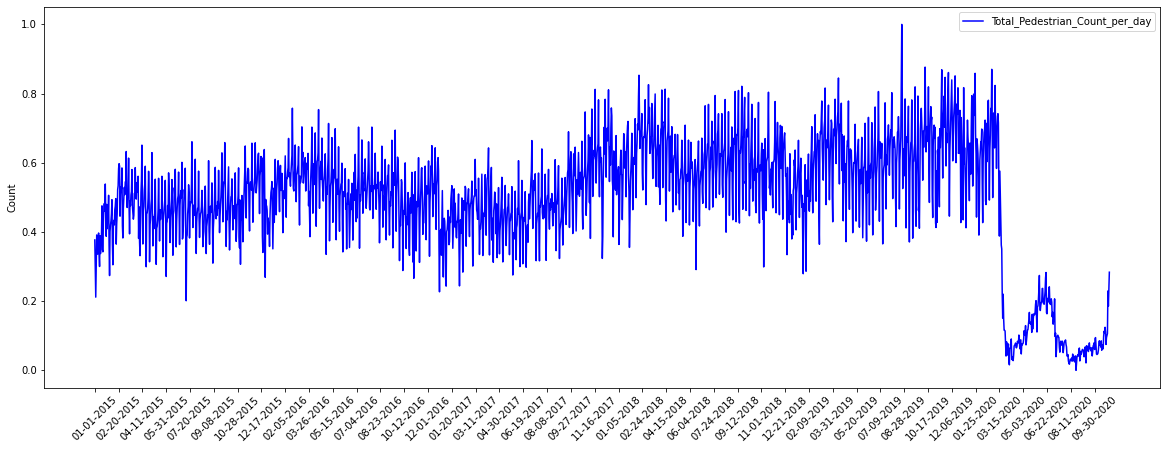

In [ ]:
# Data Normalization
scaler = MinMaxScaler()
df_norm.iloc[:,1:] = scaler.fit_transform(df_norm.iloc[:,1:].values)    # normalize feature except the date column
# test_x.iloc[:, 1:] = scaler.transform(test_x.iloc[:, 1:].values)

print('\nNormalized data')
plt.figure(figsize = (20, 7))
plt.plot(range(len(df_norm)), df_norm['Total_Pedestrian_Count_per_day'], color='blue', label='Total_Pedestrian_Count_per_day')
plt.xticks(range(0,len(df_norm),50),df_norm['Date'].loc[::50],rotation=45)
plt.ylabel('Count')
plt.legend()
plt.show()

In [ ]:
df_norm

,Date,Daily global solar exposure (MJ/m*m),Covid Restrictions,Rainfall amount (millimetres),Public_Holiday,Maximum temperature (Degree C),Minimum temperature (Degree C),Total_Pedestrian_Count_per_day
0,01-01-2015,0.702454,0.0,0.00000,1.0,0.518841,0.463504,0.376885
1,01-02-2015,0.800613,0.0,0.00000,0.0,0.863768,0.540146,0.301011
2,01-03-2015,0.791411,0.0,0.00000,0.0,0.846377,0.708029,0.211554
3,01-04-2015,0.751534,0.0,0.08042,0.0,0.359420,0.572993,0.294865
4,01-05-2015,0.920245,0.0,0.00000,0.0,0.376812,0.525547,0.391282
...,...,...,...,...,...,...,...,...
2127,10-27-2020,0.595092,1.0,0.00000,0.0,0.307246,0.383212,0.106274
2128,10-28-2020,0.797546,1.0,0.00000,0.0,0.344928,0.324818,0.229500
2129,10-29-2020,0.503067,1.0,0.00000,0.0,0.443478,0.386861,0.185415
2130,10-30-2020,0.622699,1.0,0.00000,0.0,0.278261,0.448905,0.231290


In [ ]:
### test n predict

n_past = 360           # no of past days used to predict the future
n_future = 7           # no of future days being predicted


x_train = []
y_train = []

for i in range(n_past, len(df_norm) -n_future +1):
	x_train.append(df_norm.iloc[i-n_past:i, 1:].values) # use all column apart from date as feature
	y_train.append(df_norm.iloc[i:i+n_future,-1]) # considering last column as target label

x_train, y_train = np.array(x_train), np.array(y_train)
print('Train data shape: ', x_train.shape)
print('Train Target shape: ', y_train.shape)

Train data shape:  (1766, 360, 7)
Train Target shape:  (1766, 7)


In [ ]:
 # test on last N days
LAST_N_DAYS = 30

train_x = x_train[:-LAST_N_DAYS,:,:]
train_y = y_train[:-LAST_N_DAYS,:]
print('Train data shape: ', train_x.shape)
print('Train Target shape: ', train_y.shape)

test_x = x_train[-LAST_N_DAYS:,:,:]
test_y = y_train[-LAST_N_DAYS:,:]
print('Test data shape: ', test_x.shape)
print('Test Target shape: ', test_y.shape)

Train data shape:  (1736, 360, 7)
Train Target shape:  (1736, 7)
Test data shape:  (30, 360, 7)
Test Target shape:  (30, 7)


# Simple RNN

Add SimpleRNN model here

In [ ]:
def get_model():
  np.random.seed(36)
  model = Sequential()
  model.add(SimpleRNN(50,input_shape=(train_x.shape[1], train_x.shape[2])))
  model.add(Dropout(0.3))
  model.add(Dense(256))
  model.add(Dense(train_y.shape[1]))
  return model

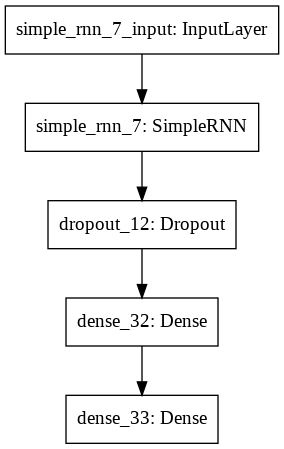

In [ ]:
# Model Visualization
model = get_model()
plot_model(model)

In [ ]:
model = get_model()
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, verbose=0, mode='min', min_delta=0.0001, min_lr=0.000000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', min_delta=0.00001)

tensorboard = TensorBoard(log_dir="logs",write_graph=True)
filepath = './best_rnn_model.hdf5'
model_check_point = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

LR = 1e-4
EPOCH = 200
opt = Adam(lr=LR, decay=LR/EPOCH)
# opt = Adam(lr=LR)
# opt = RMSprop(lr=LR)
model.compile(optimizer=opt, loss='mae')

In [ ]:
model_history = model.fit(
                            train_x, train_y, 
                            epochs=EPOCH, 
                            batch_size=32, 
                            # validation_data=(test_x, test_y)
                            validation_split=.2,
                            callbacks = [reduce_lr_on_plateau, tensorboard, model_check_point,early_stopping]
                        )

Epoch 1/200
44/44 [==============================] - 17s 357ms/step - loss: 0.4937 - val_loss: 0.1677
Epoch 2/200
44/44 [==============================] - 14s 307ms/step - loss: 0.1724 - val_loss: 0.1517
Epoch 3/200
44/44 [==============================] - 14s 311ms/step - loss: 0.1472 - val_loss: 0.1393
Epoch 4/200
44/44 [==============================] - 14s 317ms/step - loss: 0.1339 - val_loss: 0.1283
Epoch 5/200
44/44 [==============================] - 13s 305ms/step - loss: 0.1230 - val_loss: 0.1236
Epoch 6/200
44/44 [==============================] - 14s 307ms/step - loss: 0.1125 - val_loss: 0.1117
Epoch 7/200
44/44 [==============================] - 13s 302ms/step - loss: 0.1058 - val_loss: 0.1105
Epoch 8/200
44/44 [==============================] - 14s 308ms/step - loss: 0.1016 - val_loss: 0.1084
Epoch 9/200
44/44 [==============================] - 14s 312ms/step - loss: 0.0955 - val_loss: 0.1041
Epoch 10/200
44/44 [==============================] - 14s 311ms/step - loss: 0.091

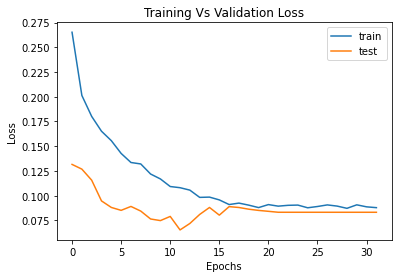

In [ ]:
# load best rnn model
rnn_best_model = keras.models.load_model(filepath)

In [ ]:
# report error. Benchmark for reference
train_pred = model.predict(train_x)
err = np.mean(np.abs(train_y-train_pred))
print('train MAE error for standard averaging:', err)

test_pred = model.predict(test_x)
err = np.mean(np.abs(test_y-test_pred))
print('test MAE error for standard averaging:', err)

train MAE error for standard averaging: 0.04625543658630555
test MAE error for standard averaging: 0.04963793676829961


In [ ]:
# report error
train_pred = rnn_best_model.predict(train_x)
err = np.mean(np.abs(train_y-train_pred))
print('train MAE error for standard averaging:', err)

test_pred = rnn_best_model.predict(test_x)
err = np.mean(np.abs(test_y-test_pred))
print('test MAE error for standard averaging:', err)

train MAE error for standard averaging: 0.06708329884337463
test MAE error for standard averaging: 0.034537805923210575


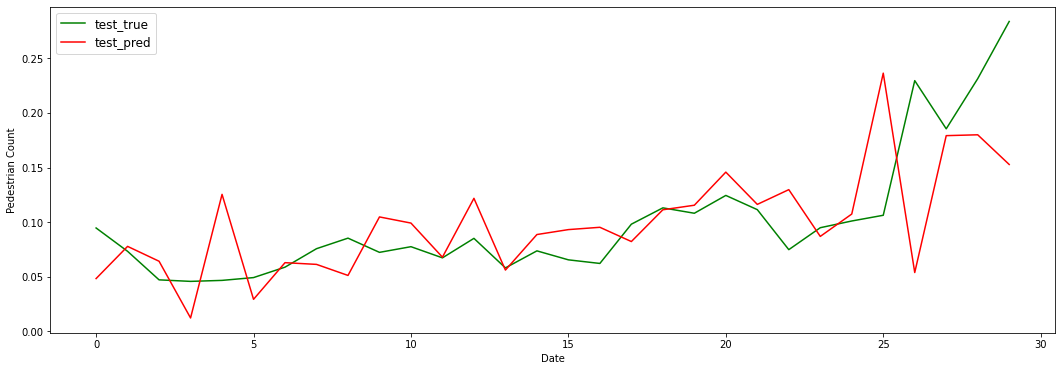

In [ ]:
plt.figure(figsize = (18,6))
# plt.plot(train_y,color='b',label='True')
# plt.plot(train_pred,color='orange',label='Predicted')
# plt.xlabel('Date')
# plt.ylabel('Close')
# plt.legend(fontsize=12)
# plt.show()
plt.plot(test_y,color='g',label='test_true')
plt.plot(test_pred,color='r',label='test_pred')
plt.xlabel('Date')
plt.ylabel('Pedestrian Count')
plt.legend(fontsize=12)
plt.show()

In [ ]:
# Tabular comparison of predicted vs ground truth
test_scaled = df_norm.iloc[-LAST_N_DAYS:,1:-1]
test_scaled['target'] = test_pred
test_scaled
test_predicted_denorm = scaler.inverse_transform(test_scaled)[:,-1]
test_true_denorm = df.iloc[-LAST_N_DAYS:,-1]

rnn_test_comp = pd.DataFrame(data = {'predicted':test_predicted_denorm, 'ground_truth':test_true_denorm})
rnn_test_comp['diff'] = (rnn_test_comp['predicted']-rnn_test_comp['ground_truth']).abs()
print(rnn_test_comp)
print('-----------------_')
print('Mean diff in prediction and ground truth', np.mean(rnn_test_comp['diff']))

          predicted  ground_truth           diff
2102  114271.442933        164619   50347.557067
2103  146306.398547        141391    4915.398547
2104  131504.683184        112983   18521.683184
2105   75044.895854        111473   36428.104146
2106  198091.112496        112459   85632.112496
2107   93602.227498        115245   21642.772502
2108  130093.372381        125631    4462.372381
2109  128385.928418        144006   15620.071582
2110  117381.398174        154509   37127.601826
2111  175624.160742        140357   35267.160742
2112  169502.746592        146003   23499.746592
2113  135551.394775        134898     653.394775
2114  194135.029521        154291   39844.029521
2115  122733.688532        124895    2161.311468
2116  158090.995271        141843   16247.995271
2117  163009.216280        132910   30099.216280
2118  165308.590301        129324   35984.590301
2119  151123.489849        168411   17287.510151
2120  182743.713192        184648    1904.286808
2121  187266.976550 

In [ ]:
def evaluate_model(y_true, y_predicted):
    scores = []
    
    #calculate scores for each day
    for i in range(y_true.shape[1]):
        mse = mean_squared_error(y_true[:, i], y_predicted[:, i])
        rmse = np.sqrt(mse)
        scores.append(rmse)
    
    #calculate score for whole prediction
    total_score = 0
    for row in range(y_true.shape[0]):
        for col in range(y_predicted.shape[1]):
            total_score = total_score + (y_true[row, col] - y_predicted[row, col])**2
    total_score = np.sqrt(total_score/(y_true.shape[0]*y_predicted.shape[1]))
    
    return total_score, scores

In [ ]:
y_pred = reg.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred)
y_true = y_scaler.inverse_transform(y_test)
evaluate_model(y_true, y_pred)
